## Package Initialization

In [0]:
import numpy as np

from scipy import stats

import math
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import networkx as nx

import matplotlib
import matplotlib.pyplot as plt

from google.colab import files

## Define DrBC Network

In [0]:
class DrBCNetwork(nn.Module):
    def __init__(self, input_dimension = 3, embedding_dimension = 128):
        super(DrBCNetwork, self).__init__()

        self.input_dimension = input_dimension
        self.embedding_dimension = embedding_dimension
        self.linear1 = nn.Linear(self.input_dimension, self.embedding_dimension, bias=False)
        self.gru_cell1 = nn.GRUCell(self.embedding_dimension, self.embedding_dimension, bias=False)
        self.gru_cell2 = nn.GRUCell(self.embedding_dimension, self.embedding_dimension, bias=False)
        self.linear2 = nn.Linear(self.embedding_dimension, int(self.embedding_dimension / 2), bias=False)
        self.linear3 = nn.Linear(int(self.embedding_dimension / 2), 1, bias=False)

        # aggregation weights look-up table
        self.aggregation_weights = None
        
        # node neighborhood look-up table
        self.neighborhood = None

        # node degree list
        self.degrees = None


    # using another graph to train => recalculate self.aggregation and self.neighborhood
    def set_graph(self, graph):

        node_number = len(list(graph.nodes))

        # get degrees and neighborhood lookup
        self.neighborhood = torch.zeros([node_number, node_number], dtype=torch.bool)
        self.degrees = torch.zeros([node_number])

        for edge in graph.edges:
            source, target = edge
            self.neighborhood[source, target] = self.neighborhood[target, source] = 1
            self.degrees[source] += 1
            self.degrees[target] += 1

        # compute aggregation weights
        self.aggregation_weights = torch.zeros([node_number, node_number], dtype=torch.float32)

        sqrt_degrees = self.degrees.sqrt()
        for i in range(node_number):
            # if i % 100 == 0:
            #    print("calculating aggregation weights: {}/{}".format(i, node_number))
            for j in range(i):
                self.aggregation_weights[i, j] = 1 / (sqrt_degrees[i].item()*sqrt_degrees[j].item() + 1e-7)

        # make it diagonal symmetry matrix
        self.aggregation_weights = self.aggregation_weights.T + self.aggregation_weights
        sqrt_degrees = None
    
    def forward(self, x):

        # Encoding
        # ============================================================================================

        # x's shape: [node_number, 3] --> use all node without batching

        h0 = x
        h1 = F.normalize(F.relu(self.linear1(h0))) # h1: [node_number, embedding_dimension]

        # neighborhood aggregation: layer 2
        h2n =  torch.mm(self.neighborhood * self.aggregation_weights, h1) # h2n: [node_number, embedding_dimension]
        
        # combination: layer 2
        h2 = self.gru_cell1(h2n, h1) # h2: [node_number, embedding_dimenstion]

        # normalize the embedding vector
        h2 = F.normalize(h2)

        # neighborhood aggregation: layer 3
        h3n = torch.mm(self.neighborhood * self.aggregation_weights, h2) # h3n: [node_number, embedding_dimension]
        
        # combination: layer 3
        h3 = self.gru_cell2(h3n, h2) # h3: [node_number, embedding_dimenstion]

        # normalize the embedding vector
        h3 = F.normalize(h3)

        # layer aggregation: element-wise max pooling
        z = torch.max(torch.max(h1, h2), h3)

        # Decoding
        # ===========================================================================================

        # 1-st fully-connected
        z = self.linear2(z)
        z = F.relu(z)

        z = self.linear3(z)

        return z

    # return degree list of current used graph, size: [node_number]
    def get_graph_degrees(self):
        return self.degrees

## Functions for Saving & Loading Model

In [0]:
def save_model(model, path='./drbc.pkl'):
    torch.save(model.state_dict(), path)

def load_model(model, path='./drbc.pkl'):
    model.load_state_dict(torch.load(path))
    model.eval()

## Define Evaluation Functions

In [0]:
class PairwiseRankingLoss(nn.Module):
    def __init__(self, sample_number):
        super(PairwiseRankingLoss, self).__init__()
        self.sample_number = sample_number
        
    def forward(self, outputs, targets):

        errors = torch.zeros([self.sample_number])

        # draw samples from prediction outputs and targets
        for i in range(self.sample_number):
            perm = torch.randperm(outputs.size(0))
            index = perm[:2]
            y_diff = outputs[index][0].item() - outputs[index][1].item()
            b_diff = targets[index][0].item() - targets[index][1].item()

            errors[i] = (-1) * self.sigmoid(b_diff) * math.log( self.sigmoid(y_diff) ) - (1 - self.sigmoid(b_diff)) * math.log(1 - self.sigmoid(y_diff))

        return torch.sum(errors)

    def sigmoid(self, x):
        return (1 / (1 + math.exp( -1 * x )))

In [0]:
def SoftmaxLoss(outputs, targets):
    # softmax
    return torch.sum(torch.abs(F.softmax(outputs, dim=0) - F.softmax(targets, dim=0)))

In [0]:
def TopNAccuracy(outputs, targets):
    sorted_output_indexs = torch.argsort(outputs, dim=0, descending=True)
    sorted_target_indexs = torch.argsort(targets, dim=0, descending=True)

    node_number = outputs.size(0)

    # top-10%
    candidate_number = int(node_number * (10 / 100))
    hits = 0
    for out in sorted_output_indexs[:candidate_number]:
        if out in sorted_target_indexs[:candidate_number]:
            hits += 1
    acc_10 = hits/candidate_number

    # top-5%
    candidate_number = int(node_number * (5 / 100))
    hits = 0
    for out in sorted_output_indexs[:candidate_number]:
        if out in sorted_target_indexs[:candidate_number]:
            hits += 1
    acc_5 = hits/candidate_number

    # top-1%
    candidate_number = int(node_number * (1 / 100))
    hits = 0
    for out in sorted_output_indexs[:candidate_number]:
        if out in sorted_target_indexs[:candidate_number]:
            hits += 1
    acc_1 = hits/candidate_number

    return (acc_1*100, acc_5*100, acc_10*100)

In [0]:
def KendallTauDistance(outputs, targets):
    return stats.kendalltau(outputs.detach(), targets).correlation*100

## Define Training Constants

In [0]:
# constants
TRAINING_GRAPHS = 10
GRAPH_NODES = 500
LEARNING_RATE = 0.0001
EPOCHS = 1
VALIDATION_GRAPHS = 1

INPUT_DIMENSION = 3
EMBEDDING_DIMENSION = 128

MODEL_PATH = './drbc.pkl'

## Build Training Procedure

In [0]:
# create model entity
drbc = DrBCNetwork(input_dimension=INPUT_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION)

# create optimizer (Adam used)
optimizer = optim.Adam(drbc.parameters(), lr=LEARNING_RATE)

In [0]:
# [Optional] !
load_model(drbc, path = MODEL_PATH)

In [0]:
# create set of graphs for validation
print("Preparing validation graphs ...")
validation_graphs = [nx.powerlaw_cluster_graph(n=GRAPH_NODES, m=4, p=0.05) for i in range(VALIDATION_GRAPHS)]
validation_scores = []
for g in validation_graphs:
    validation_scores.append(torch.Tensor(list(nx.betweenness_centrality(g).values())).unsqueeze(1))

# record the training/validation loss, top-N% accuracy and Kendall-tau distance
history = {
        'training': {
            'loss': torch.zeros([TRAINING_GRAPHS * EPOCHS]),
            'top1a': torch.zeros([TRAINING_GRAPHS * EPOCHS]),
            'top5a': torch.zeros([TRAINING_GRAPHS * EPOCHS]),
            'top10a': torch.zeros([TRAINING_GRAPHS * EPOCHS]),
            'kdt': torch.zeros([TRAINING_GRAPHS * EPOCHS])
        },
        'validation': {
            'loss': torch.zeros([TRAINING_GRAPHS]),
            'top1a': torch.zeros([TRAINING_GRAPHS]),
            'top5a': torch.zeros([TRAINING_GRAPHS]),
            'top10a': torch.zeros([TRAINING_GRAPHS]),
            'kdt': torch.zeros([TRAINING_GRAPHS])
        }
    }

Preparing validation graphs ...


In [0]:
# training

for i in range(TRAINING_GRAPHS):

    print("=== Training on Graph {} ===".format(i))
    
    # generate graph G
    graph = nx.powerlaw_cluster_graph(n=GRAPH_NODES, m=4, p=0.05)
    
    # get betweeness centrality of graph's nodes, format it into scores
    node_scores = torch.Tensor(list(nx.betweenness_centrality(graph).values())).unsqueeze(1) # torch.Size([GRAPH_NODES, 1])

    # recalculate aggregation weights, neighborhood lookup and node degrees
    drbc.set_graph(graph)

    # prepare input data x
    degrees = drbc.get_graph_degrees()
    x = torch.ones([GRAPH_NODES, 3])
    for j in range(GRAPH_NODES):
        x[j][0] = degrees[j]

    # training
    for j in range(EPOCHS):
        optimizer.zero_grad()   # zero the gradient buffers
        z = drbc(x)

        loss = SoftmaxLoss(z, node_scores)
        # print("Epoch {}'s loss: {}".format(j, loss))
        history['training']['loss'][i*EPOCHS + j] = loss

        # top-N% accuracy
        accuracy_1, accuracy_5, accuracy_10 = TopNAccuracy(z, node_scores)
        # print("Epoch {}'s top-10% accuracy: {:.2f}%, top-5% accuracy: {:.2f}%, top-1% accuracy: {:.2f}%".format(j, accuracy_10, accuracy_5, accuracy_1))
        history['training']['top1a'][i*EPOCHS + j] = accuracy_1
        history['training']['top5a'][i*EPOCHS + j] = accuracy_5
        history['training']['top10a'][i*EPOCHS + j] = accuracy_10

        # kendall tau distance
        kdt = KendallTauDistance(z, node_scores)
        history['training']['kdt'][i*EPOCHS + j] = kdt

        loss.backward()
        optimizer.step()

        save_model(drbc, path=MODEL_PATH)

        # do validation at the last epochs
        if (j == (EPOCHS-1)):
            val_losses = torch.zeros([VALIDATION_GRAPHS])
            val_acc1s = torch.zeros([VALIDATION_GRAPHS])
            val_acc5s = torch.zeros([VALIDATION_GRAPHS])
            val_acc10s = torch.zeros([VALIDATION_GRAPHS])
            val_kdts = torch.zeros([VALIDATION_GRAPHS])
            for k in range(VALIDATION_GRAPHS):
                drbc.set_graph(validation_graphs[k])

                # set model using validation graph
                deg = drbc.get_graph_degrees()

                # prepare input x for validation
                val_x = torch.ones([GRAPH_NODES, 3])
                for m in range(GRAPH_NODES):
                    val_x[m][0] = deg[m]

                val_z = drbc(val_x)
                val_losses[k] = SoftmaxLoss(val_z, validation_scores[k])

                accuracy_1, accuracy_5, accuracy_10 = TopNAccuracy(val_z, validation_scores[k])
                val_acc1s[k] = accuracy_1
                val_acc5s[k] = accuracy_5
                val_acc10s[k] = accuracy_10

                # kendall tau distance
                kdt = KendallTauDistance(z, node_scores)
                val_kdts[k] = kdt

            history['validation']['loss'][i] = torch.mean(val_losses)
            history['validation']['top1a'][i] = torch.mean(val_acc1s)
            history['validation']['top5a'][i] = torch.mean(val_acc5s)
            history['validation']['top10a'][i] = torch.mean(val_acc10s)
            history['validation']['kdt'][i] = torch.mean(val_kdts)

## Build Training Procedure (Functional)

In [0]:
# create drbc model, train on synthetic data, save model
def train_model(training_graphs=TRAINING_GRAPHS, graph_nodes=GRAPH_NODES, learning_rate=LEARNING_RATE,
                epochs=EPOCHS, validation_number=VALIDATION_GRAPHS,
                input_dimension=INPUT_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION,
                save_path=MODEL_PATH):
    
    # create model entity
    drbc = DrBCNetwork(input_dimension=input_dimension, embedding_dimension=embedding_dimension)

    # create optimizer (Adam used)
    optimizer = optim.Adam(drbc.parameters(), lr=learning_rate)

    # create set of graphs for validation
    print("Preparing validation graphs ...")
    validation_graphs = [nx.powerlaw_cluster_graph(n=graph_nodes, m=4, p=0.05) for i in range(validation_number)]
    validation_scores = []
    for g in validation_graphs:
        validation_scores.append(torch.Tensor(list(nx.betweenness_centrality(g).values())).unsqueeze(1))

    # record the training/validation loss, top-N% accuracy and Kendall-tau distance
    history = {
            'training': {
                'loss': torch.zeros([training_graphs * epochs]),
                'top1a': torch.zeros([training_graphs * epochs]),
                'top5a': torch.zeros([training_graphs * epochs]),
                'top10a': torch.zeros([training_graphs * epochs]),
                'kdt': torch.zeros([training_graphs * epochs])
            },
            'validation': {
                'loss': torch.zeros([training_graphs]),
                'top1a': torch.zeros([training_graphs]),
                'top5a': torch.zeros([training_graphs]),
                'top10a': torch.zeros([training_graphs]),
                'kdt': torch.zeros([training_graphs])
            }
        }

    # training

    for i in range(training_graphs):

        if (i%2 == 0):
            print("=== Training on Graph {} ===".format(i))
        
        # generate graph G
        graph = nx.powerlaw_cluster_graph(n=graph_nodes, m=4, p=0.05)
        
        # get betweeness centrality of graph's nodes, format it into scores
        node_scores = torch.Tensor(list(nx.betweenness_centrality(graph).values())).unsqueeze(1) # torch.Size([GRAPH_NODES, 1])

        # recalculate aggregation weights, neighborhood lookup and node degrees
        drbc.set_graph(graph)

        # prepare input data x
        degrees = drbc.get_graph_degrees()
        x = torch.ones([graph_nodes, 3])
        for j in range(graph_nodes):
            x[j][0] = degrees[j]

        # training
        for j in range(epochs):
            optimizer.zero_grad()   # zero the gradient buffers
            z = drbc(x)

            loss = SoftmaxLoss(z, node_scores)
            # print("Epoch {}'s loss: {}".format(j, loss))
            history['training']['loss'][i*epochs + j] = loss

            # top-N% accuracy
            accuracy_1, accuracy_5, accuracy_10 = TopNAccuracy(z, node_scores)
            # print("Epoch {}'s top-10% accuracy: {:.2f}%, top-5% accuracy: {:.2f}%, top-1% accuracy: {:.2f}%".format(j, accuracy_10, accuracy_5*, accuracy_1))
            history['training']['top1a'][i*epochs + j] = accuracy_1
            history['training']['top5a'][i*epochs + j] = accuracy_5
            history['training']['top10a'][i*epochs + j] = accuracy_10

            # kendall tau distance
            kdt = KendallTauDistance(z, node_scores)
            history['training']['kdt'][i*epochs + j] = kdt

            loss.backward()
            optimizer.step()

            # do validation at the last epochs
            if (j == (epochs-1)):
                val_losses = torch.zeros([validation_number])
                val_acc1s = torch.zeros([validation_number])
                val_acc5s = torch.zeros([validation_number])
                val_acc10s = torch.zeros([validation_number])
                val_kdts = torch.zeros([validation_number])
                for k in range(validation_number):
                    drbc.set_graph(validation_graphs[k])

                    # set model using validation graph
                    deg = drbc.get_graph_degrees()

                    # prepare input x for validation
                    val_x = torch.ones([graph_nodes, 3])
                    for m in range(graph_nodes):
                        val_x[m][0] = deg[m]

                    val_z = drbc(val_x)
                    val_losses[k] = SoftmaxLoss(val_z, validation_scores[k])

                    accuracy_1, accuracy_5, accuracy_10 = TopNAccuracy(val_z, validation_scores[k])
                    val_acc1s[k] = accuracy_1
                    val_acc5s[k] = accuracy_5
                    val_acc10s[k] = accuracy_10

                    # kendall tau distance
                    kdt = KendallTauDistance(val_z, validation_scores[k])
                    val_kdts[k] = kdt

                history['validation']['loss'][i] = torch.mean(val_losses)
                history['validation']['top1a'][i] = torch.mean(val_acc1s)
                history['validation']['top5a'][i] = torch.mean(val_acc5s)
                history['validation']['top10a'][i] = torch.mean(val_acc10s)
                history['validation']['kdt'][i] = torch.mean(val_kdts)

        save_model(drbc, path=save_path)


    fig, axs = plt.subplots(1, 4, figsize=(24, 6))

    axs[0].plot(np.arange(1, training_graphs*epochs+1, 1), history['training']['loss'].detach().numpy(), label='Training')
    axs[0].plot(np.arange(epochs, training_graphs*epochs+1, epochs), history['validation']['loss'].detach().numpy(), label='Validation')
    axs[0].legend()
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[0].set_title("Loss")

    axs[1].plot(np.arange(1, training_graphs*epochs+1, 1), history['training']['top10a'].numpy(), label='Traing')
    axs[1].plot(np.arange(epochs, training_graphs*epochs+1, epochs), history['validation']['top10a'].numpy(), label='Validation')
    axs[1].legend()
    axs[1].set_title('Top-10% Accuracy')
    axs[1].set_ylim([0, 101])
    axs[1].set(xlabel='epochs', ylabel='accuracy(%)')

    axs[2].plot(np.arange(1, training_graphs*epochs+1, 1), history['training']['top5a'].numpy(), label='Traing')
    axs[2].plot(np.arange(epochs, training_graphs*epochs+1, epochs), history['validation']['top5a'].numpy(), label='Validation')
    axs[2].legend()
    axs[2].set_title('Top-5% Accuracy')
    axs[2].set_ylim([0, 101])
    axs[2].set(xlabel='epochs', ylabel='accuracy(%)')

    axs[3].plot(np.arange(1, training_graphs*epochs+1, 1), history['training']['top1a'].numpy(), label='Traing')
    axs[3].plot(np.arange(epochs, training_graphs*epochs+1, epochs), history['validation']['top1a'].numpy(), label='Validation')
    axs[3].legend()
    axs[3].set_title('Top-1% Accuracy')
    axs[3].set_ylim([0, 101])
    axs[3].set(xlabel='epochs', ylabel='accuracy(%)')

    return history

## Experiments
- [x] Train models using many graphs, few epoch vs few graphs, many epochs
- [x] Train 5 models using different sizes of graphs: 200, 300, 1000, 2000, 4000
- [x] Parse text testing data (size: 5K / size: 1M)  to `networkx` object
- [x] Do test using 5 different models on 5K/1M testing data, record:
  * [x] Top-1% , Top-5% , Top-10% accuracy
  * [x] Kendall tau distance
  * [x] Running time

Train using many graphs, few epoch vs. few graphs, many epochs

Preparing validation graphs ...
=== Training on Graph 0 ===


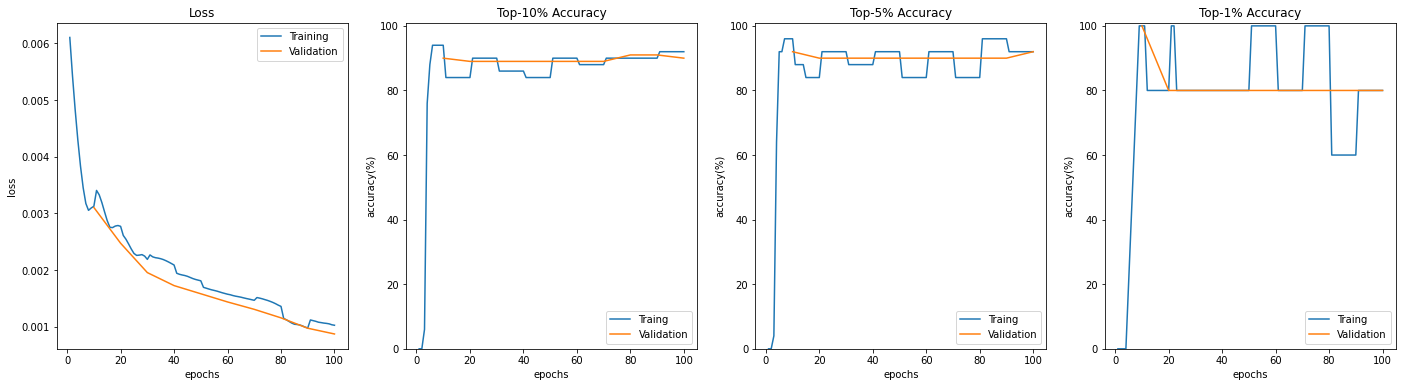

In [49]:
_ = train_model(training_graphs=10, graph_nodes=500, learning_rate=LEARNING_RATE,
                epochs=10, validation_number=2,
                input_dimension=INPUT_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION,
                save_path='./drbc_no.pkl')

Preparing validation graphs ...
=== Training on Graph 0 ===
=== Training on Graph 10 ===
=== Training on Graph 20 ===
=== Training on Graph 30 ===
=== Training on Graph 40 ===
=== Training on Graph 50 ===
=== Training on Graph 60 ===
=== Training on Graph 70 ===
=== Training on Graph 80 ===
=== Training on Graph 90 ===


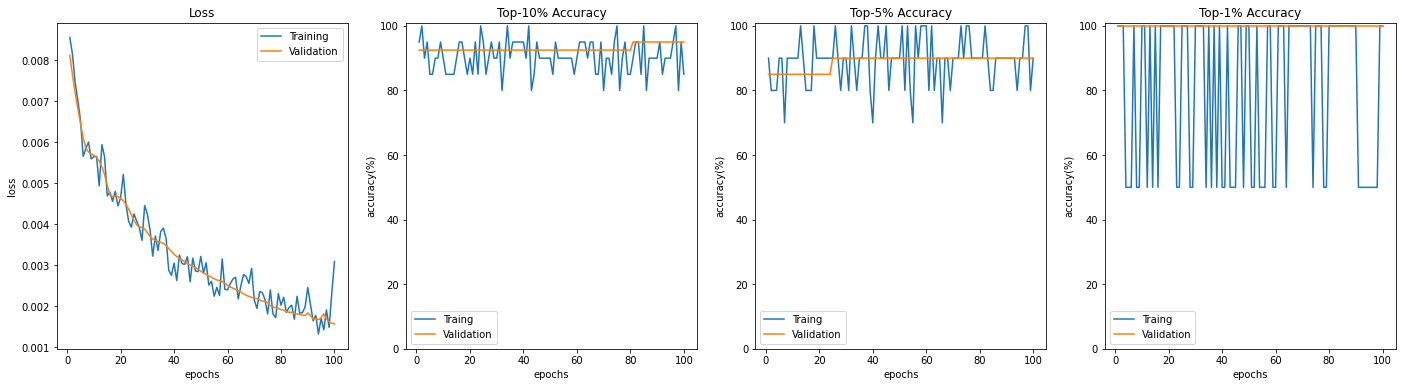

In [52]:
_ = train_model(training_graphs=100, graph_nodes=200, learning_rate=LEARNING_RATE,
                epochs=1, validation_number=2,
                input_dimension=INPUT_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION,
                save_path='./drbc_no.pkl')

1.train a model using graphs has 200 nodes

Preparing validation graphs ...
=== Training on Graph 0 ===


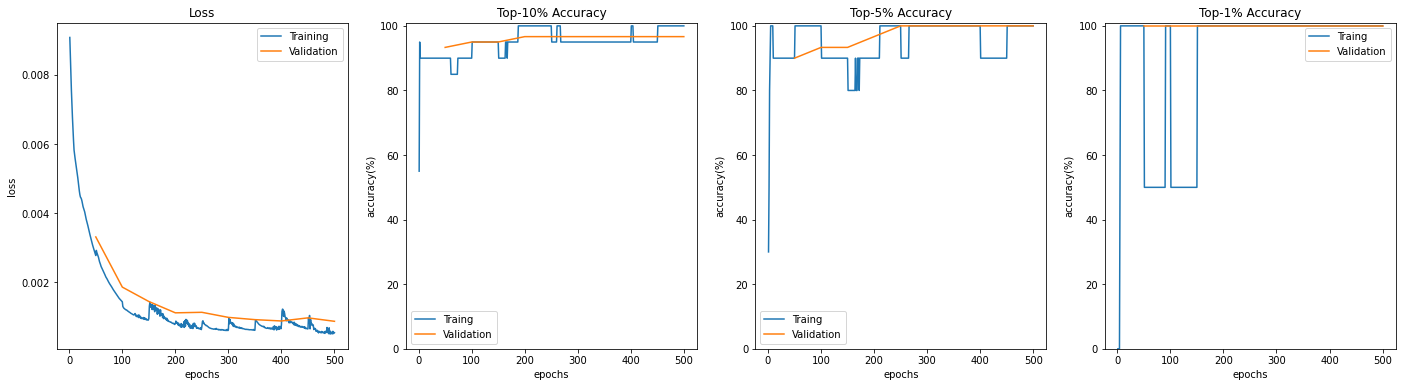

In [9]:
history_200 = train_model(training_graphs=10, graph_nodes=200, learning_rate=LEARNING_RATE,
                epochs=50, validation_number=3,
                input_dimension=INPUT_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION,
                save_path='./drbc_200.pkl')

2.train a model using graphs has 300 nodes

Preparing validation graphs ...
=== Training on Graph 0 ===


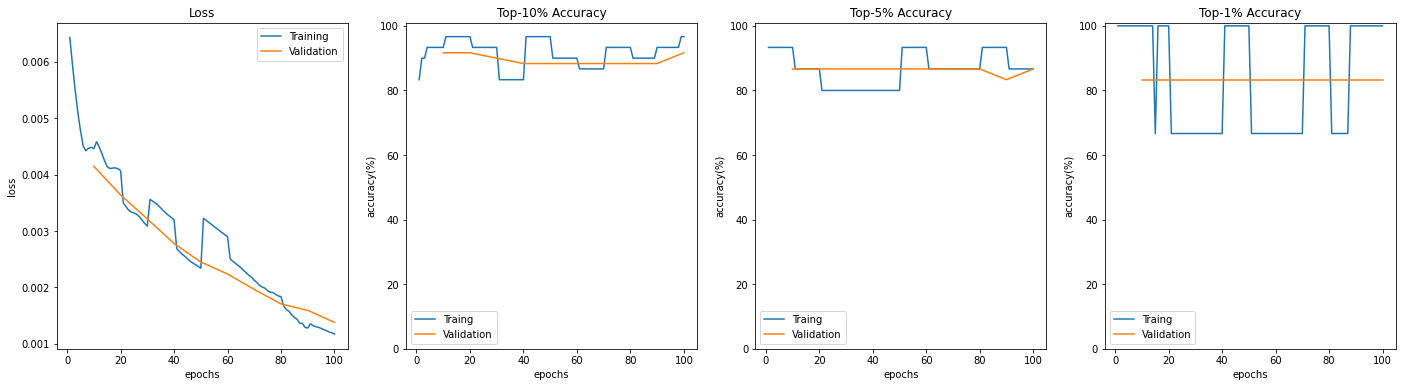

In [10]:
history_300 = train_model(training_graphs=10, graph_nodes=300, learning_rate=LEARNING_RATE,
                epochs=10, validation_number=2,
                input_dimension=INPUT_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION,
                save_path='./drbc_300.pkl')

3.train a model using graphs has 1000 nodes

Preparing validation graphs ...
=== Training on Graph 0 ===


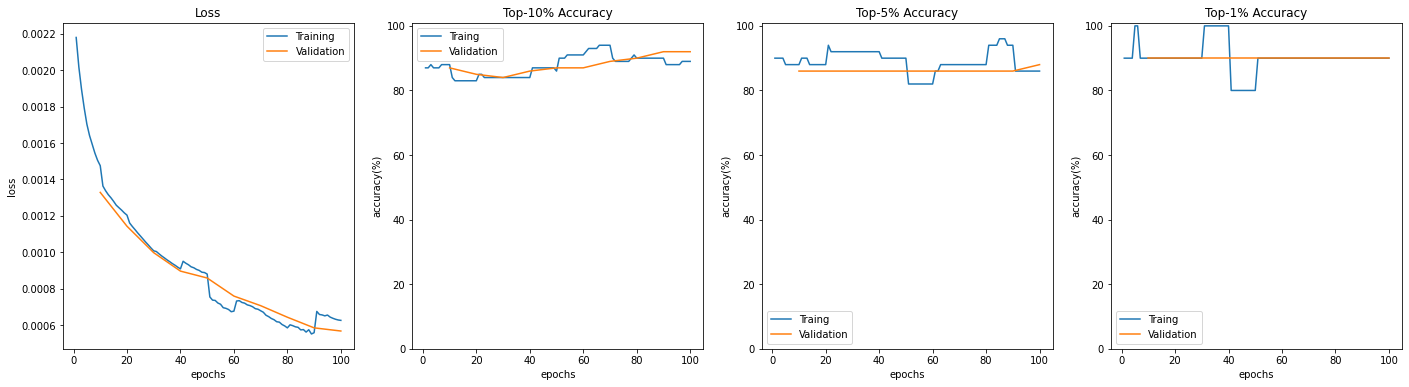

In [11]:
history_1000 = train_model(training_graphs=10, graph_nodes=1000, learning_rate=LEARNING_RATE,
                epochs=10, validation_number=1,
                input_dimension=INPUT_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION,
                save_path='./drbc_1000.pkl')

4.train a model using graphs has 2000 nodes

Preparing validation graphs ...
=== Training on Graph 0 ===
=== Training on Graph 2 ===


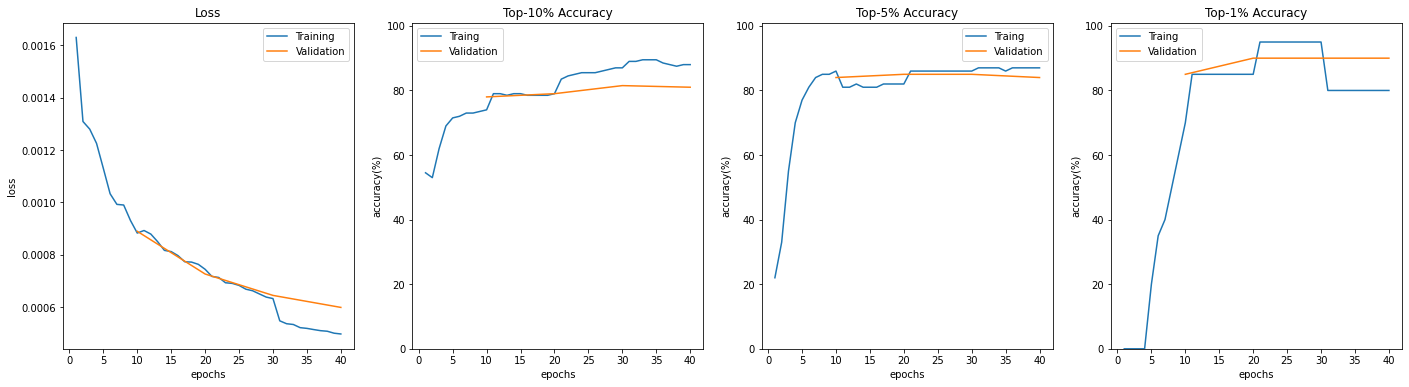

In [13]:
history_2000 = train_model(training_graphs=4, graph_nodes=2000, learning_rate=LEARNING_RATE,
                epochs=10, validation_number=1,
                input_dimension=INPUT_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION,
                save_path='./drbc_2000.pkl')

5.train a model using graphs has 4000 nodes

Preparing validation graphs ...
=== Training on Graph 0 ===


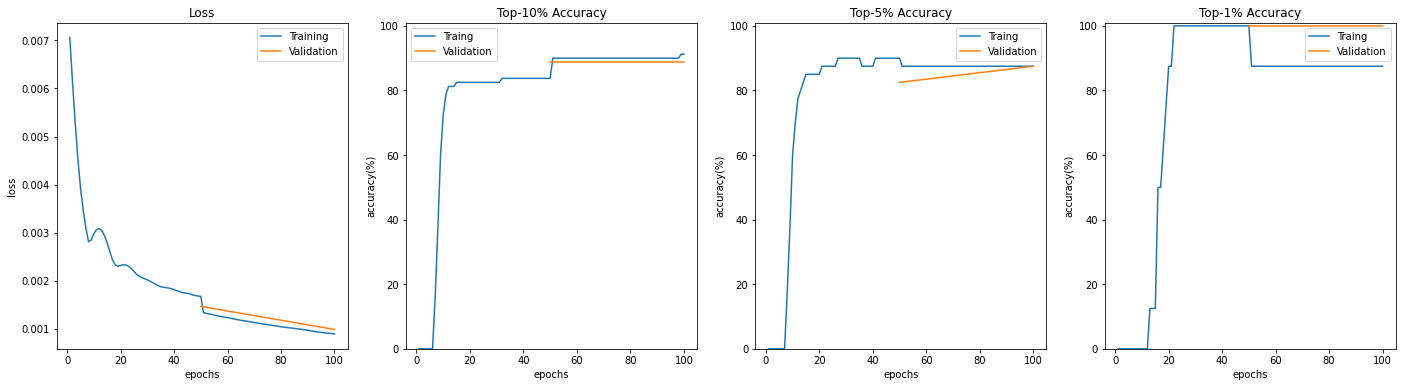

In [17]:
history_4000 = train_model(training_graphs=2, graph_nodes=4000, learning_rate=LEARNING_RATE,
                epochs=50, validation_number=1,
                input_dimension=INPUT_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION,
                save_path='./drbc_4000.pkl')

6.Parse text testing data (size: 5K / size: 1M) to networkx object

In [0]:
# function to get torch_geometric.data.Data object from sythnetic graph
def get_synthetic_test_data(number = 0):

    # read network file
    graph = nx.Graph()
    with open(str(number) + ".txt", "r") as file:
        lines = file.readlines();

        for line in lines:
            if len(line) == 0:
                continue
            edge = line.split("\t")
            graph.add_edge(int(edge[0]), int(edge[1]))

    # read node score file
    node_scores = []
    with open(str(number) + "_score.txt", "r") as file:
        lines = file.readlines();

        for line in lines:
            if len(line) == 0:
                continue
            sequences = line.split("\t")
            node_scores.append(float(sequences[1]))

        node_scores = torch.tensor(np.array(node_scores), dtype=torch.float).unsqueeze(1)

    return (graph, node_scores)

In [0]:
# function to get torch_geometric.data.Data object from sythnetic graph
def get_youtube_test_data():

    # read network file
    graph = nx.Graph()
    with open("com-youtube.txt", "r") as file:
        lines = file.readlines();

        for line in lines:
            if len(line) == 0:
                continue
            edge = line.split(" ")
            graph.add_edge(int(edge[0]), int(edge[1]))

    # read node score file
    node_scores = []
    with open("com-youtube_score.txt", "r") as file:
        lines = file.readlines();

        for line in lines:
            if len(line) == 0:
                continue
            sequences = line.split(":\t")
            node_scores.append(float(sequences[1]))

        node_scores = torch.tensor(np.array(node_scores), dtype=torch.float).unsqueeze(1)

    return (graph, node_scores)

7.Do testing

In [0]:
# prepare data
syn_graph, syn_node_scores = get_synthetic_test_data(0)
syn_node_number = syn_node_scores.size(0)

syn_degrees = torch.zeros([syn_node_number])

for edge in syn_graph.edges:
    source, target = edge
    syn_degrees[source] += 1
    syn_degrees[target] += 1

syn_x = torch.ones([syn_node_number, 3])
for j in range(syn_node_number):
    syn_x[j][0] = syn_degrees[j]

syn_degrees = None

In [0]:
# prepare data
yt_graph, yt_node_scores = get_youtube_test_data()
yt_node_number = yt_node_scores.size(0)

yt_degrees = torch.zeros([yt_node_number])

for edge in yt_graph.edges:
    source, target = edge
    yt_degrees[source] += 1
    yt_degrees[target] += 1

yt_x = torch.ones([yt_node_number, 3])
for j in range(yt_node_number):
    yt_x[j][0] = yt_degrees[j]

yt_degrees = None

test for synthetic data

In [0]:
# load model trained using 200 nodes

drbc = DrBCNetwork(input_dimension=INPUT_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION)

In [0]:
print("Setting graph into model")
drbc.set_graph(syn_graph)

In [0]:
load_model(drbc, path='./drbc_200.pkl')

In [0]:
print("Predicting")
syn_z = drbc(syn_x)

syn_start_time = datetime.datetime.now()

syn_loss = SoftmaxLoss(syn_z, syn_node_scores)
print("Loss: {}".format(syn_loss))

# top-N% accuracy
syn_accuracy_1, syn_accuracy_5, syn_accuracy_10 = TopNAccuracy(syn_z, syn_node_scores)
print("Top-10% accuracy: {:.3f}%, Top-5% accuracy: {:.3f}%, Top-1% accuracy: {:.3f}%".format(syn_accuracy_10, syn_accuracy_5, syn_accuracy_1))

# kendall tau distance
syn_kdt = KendallTauDistance(syn_z, syn_node_scores)
print("Kendall Tau Disance: {}".format(syn_kdt))

# running time
syn_end_time = datetime.datetime.now()
syn_running_time = (syn_end_time - syn_start_time)
print("Running Time: {}s".format(syn_running_time.total_seconds()))

Predicting
Loss: 0.00677102617919445
Top-10% accuracy: 80.000%, Top-5% accuracy: 81.200%, Top-1% accuracy: 96.000%
Kendall Tau Disance: 57.42030702953331
Running Time: 0.024171s


In [0]:
load_model(drbc, path='./drbc_300.pkl')

In [0]:
print("Predicting")
syn_z = drbc(syn_x)

syn_start_time = datetime.datetime.now()

syn_loss = SoftmaxLoss(syn_z, syn_node_scores)
print("Loss: {}".format(syn_loss))

# top-N% accuracy
syn_accuracy_1, syn_accuracy_5, syn_accuracy_10 = TopNAccuracy(syn_z, syn_node_scores)
print("Top-10% accuracy: {:.3f}%, Top-5% accuracy: {:.3f}%, Top-1% accuracy: {:.3f}%".format(syn_accuracy_10, syn_accuracy_5, syn_accuracy_1))

# kendall tau distance
syn_kdt = KendallTauDistance(syn_z, syn_node_scores)
print("Kendall Tau Disance: {}".format(syn_kdt))

# running time
syn_end_time = datetime.datetime.now()
syn_running_time = (syn_end_time - syn_start_time)
print("Running Time: {}s".format(syn_running_time.total_seconds()))

Predicting
Loss: 0.007370683364570141
Top-10% accuracy: 78.400%, Top-5% accuracy: 81.200%, Top-1% accuracy: 96.000%
Kendall Tau Disance: 60.70773040269917
Running Time: 0.019952s


In [0]:
load_model(drbc, path='./drbc_1000.pkl')

In [0]:
print("Predicting")
syn_z = drbc(syn_x)

syn_start_time = datetime.datetime.now()

syn_loss = SoftmaxLoss(syn_z, syn_node_scores)
print("Loss: {}".format(syn_loss))

# top-N% accuracy
syn_accuracy_1, syn_accuracy_5, syn_accuracy_10 = TopNAccuracy(syn_z, syn_node_scores)
print("Top-10% accuracy: {:.3f}%, Top-5% accuracy: {:.3f}%, Top-1% accuracy: {:.3f}%".format(syn_accuracy_10, syn_accuracy_5, syn_accuracy_1))

# kendall tau distance
syn_kdt = KendallTauDistance(syn_z, syn_node_scores)
print("Kendall Tau Disance: {}".format(syn_kdt))

# running time
syn_end_time = datetime.datetime.now()
syn_running_time = (syn_end_time - syn_start_time)
print("Running Time: {}s".format(syn_running_time.total_seconds()))

Predicting
Loss: 0.003459720639511943
Top-10% accuracy: 79.200%, Top-5% accuracy: 81.200%, Top-1% accuracy: 96.000%
Kendall Tau Disance: 58.65455533434466
Running Time: 0.019941s


In [0]:
load_model(drbc, path='./drbc_2000.pkl')

In [0]:
print("Predicting")
syn_z = drbc(syn_x)

syn_start_time = datetime.datetime.now()

syn_loss = SoftmaxLoss(syn_z, syn_node_scores)
print("Loss: {}".format(syn_loss))

# top-N% accuracy
syn_accuracy_1, syn_accuracy_5, syn_accuracy_10 = TopNAccuracy(syn_z, syn_node_scores)
print("Top-10% accuracy: {:.3f}%, Top-5% accuracy: {:.3f}%, Top-1% accuracy: {:.3f}%".format(syn_accuracy_10, syn_accuracy_5, syn_accuracy_1))

# kendall tau distance
syn_kdt = KendallTauDistance(syn_z, syn_node_scores)
print("Kendall Tau Disance: {}".format(syn_kdt))

# running time
syn_end_time = datetime.datetime.now()
syn_running_time = (syn_end_time - syn_start_time)
print("Running Time: {}s".format(syn_running_time.total_seconds()))

Predicting
Loss: 0.0024432665668427944
Top-10% accuracy: 80.400%, Top-5% accuracy: 80.800%, Top-1% accuracy: 94.000%
Kendall Tau Disance: 69.09016596008767
Running Time: 0.021768s


In [0]:
load_model(drbc, path='./drbc_4000.pkl')

In [0]:
print("Predicting")
syn_z = drbc(syn_x)

syn_start_time = datetime.datetime.now()

syn_loss = SoftmaxLoss(syn_z, syn_node_scores)
print("Loss: {}".format(syn_loss))

# top-N% accuracy
syn_accuracy_1, syn_accuracy_5, syn_accuracy_10 = TopNAccuracy(syn_z, syn_node_scores)
print("Top-10% accuracy: {:.3f}%, Top-5% accuracy: {:.3f}%, Top-1% accuracy: {:.3f}%".format(syn_accuracy_10, syn_accuracy_5, syn_accuracy_1))

# kendall tau distance
syn_kdt = KendallTauDistance(syn_z, syn_node_scores)
print("Kendall Tau Disance: {}".format(syn_kdt))

# running time
syn_end_time = datetime.datetime.now()
syn_running_time = (syn_end_time - syn_start_time)
print("Running Time: {}s".format(syn_running_time.total_seconds()))

Predicting
Loss: 0.0018819504184648395
Top-10% accuracy: 80.600%, Top-5% accuracy: 81.600%, Top-1% accuracy: 96.000%
Kendall Tau Disance: 67.4971264241408
Running Time: 0.018891s


test for Youtube data

In [0]:
print("Setting graph into model")
drbc.set_graph(yt_graph)

Setting graph into model


In [0]:
load_model(drbc, path='./drbc_200.pkl')

print("Predicting")
yt_z = drbc(yt_x)

yt_start_time = datetime.datetime.now()

yt_loss = SoftmaxLoss(yt_z, yt_node_scores)
print("Loss: {}".format(yt_loss))

# top-N% accuracy
yt_accuracy_1, yt_accuracy_5, yt_accuracy_10 = TopNAccuracy(yt_z, yt_node_scores)
print("Top-10% accuracy: {:.3f}%, Top-5% accuracy: {:.3f}%, Top-1% accuracy: {:.3f}%".format(yt_accuracy_10, yt_accuracy_5, yt_accuracy_1))

# kendall tau distance
yt_kdt = KendallTauDistance(yt_z, yt_node_scores)
print("Kendall Tau Disance: {}".format(yt_kdt))

# running time
yt_end_time = datetime.datetime.now()
yt_running_time = (yt_end_time - yt_start_time)
print("Running Time: {}s".format(yt_running_time.total_seconds()))

Predicting
Loss: 0.006759893614798784
Top-10% accuracy: 81.800%, Top-5% accuracy: 82.000%, Top-1% accuracy: 92.000%
Kendall Tau Disance: 58.544287591691116
Running Time: 8.21344s


In [0]:
load_model(drbc, path='./drbc_300.pkl')

print("Predicting")
yt_z = drbc(yt_x)

yt_start_time = datetime.datetime.now()

yt_loss = SoftmaxLoss(yt_z, yt_node_scores)
print("Loss: {}".format(yt_loss))

# top-N% accuracy
yt_accuracy_1, yt_accuracy_5, yt_accuracy_10 = TopNAccuracy(yt_z, yt_node_scores)
print("Top-10% accuracy: {:.3f}%, Top-5% accuracy: {:.3f}%, Top-1% accuracy: {:.3f}%".format(yt_accuracy_10, yt_accuracy_5, yt_accuracy_1))

# kendall tau distance
yt_kdt = KendallTauDistance(yt_z, yt_node_scores)
print("Kendall Tau Disance: {}".format(yt_kdt))

# running time
yt_end_time = datetime.datetime.now()
yt_running_time = (yt_end_time - yt_start_time)
print("Running Time: {}s".format(yt_running_time.total_seconds()))

Predicting
Loss: 0.007297701667994261
Top-10% accuracy: 81.000%, Top-5% accuracy: 81.600%, Top-1% accuracy: 92.000%
Kendall Tau Disance: 61.668871041492636
Running Time: 6.23401s


In [0]:
load_model(drbc, path='./drbc_1000.pkl')

print("Predicting")
yt_z = drbc(yt_x)

yt_start_time = datetime.datetime.now()

yt_loss = SoftmaxLoss(yt_z, yt_node_scores)
print("Loss: {}".format(yt_loss))

# top-N% accuracy
yt_accuracy_1, yt_accuracy_5, yt_accuracy_10 = TopNAccuracy(yt_z, yt_node_scores)
print("Top-10% accuracy: {:.3f}%, Top-5% accuracy: {:.3f}%, Top-1% accuracy: {:.3f}%".format(yt_accuracy_10, yt_accuracy_5, yt_accuracy_1))

# kendall tau distance
yt_kdt = KendallTauDistance(yt_z, yt_node_scores)
print("Kendall Tau Disance: {}".format(yt_kdt))

# running time
yt_end_time = datetime.datetime.now()
yt_running_time = (yt_end_time - yt_start_time)
print("Running Time: {}s".format(yt_running_time.total_seconds()))

Predicting
Loss: 0.0034168786369264126
Top-10% accuracy: 81.400%, Top-5% accuracy: 81.600%, Top-1% accuracy: 92.000%
Kendall Tau Disance: 60.23758756503056
Running Time: 8.92411s


In [0]:
load_model(drbc, path='./drbc_2000.pkl')

print("Predicting")
yt_z = drbc(yt_x)

yt_start_time = datetime.datetime.now()

yt_loss = SoftmaxLoss(yt_z, yt_node_scores)
print("Loss: {}".format(yt_loss))

# top-N% accuracy
yt_accuracy_1, yt_accuracy_5, yt_accuracy_10 = TopNAccuracy(yt_z, yt_node_scores)
print("Top-10% accuracy: {:.3f}%, Top-5% accuracy: {:.3f}%, Top-1% accuracy: {:.3f}%".format(yt_accuracy_10, yt_accuracy_5, yt_accuracy_1))

# kendall tau distance
yt_kdt = KendallTauDistance(yt_z, yt_node_scores)
print("Kendall Tau Disance: {}".format(yt_kdt))

# running time
yt_end_time = datetime.datetime.now()
yt_running_time = (yt_end_time - yt_start_time)
print("Running Time: {}s".format(yt_running_time.total_seconds()))

Predicting
Loss: 0.002411940135061741
Top-10% accuracy: 82.800%, Top-5% accuracy: 81.200%, Top-1% accuracy: 90.000%
Kendall Tau Disance: 70.07168557726497
Running Time: 7.53471s


In [0]:
load_model(drbc, path='./drbc_4000.pkl')

print("Predicting")
yt_z = drbc(yt_x)

yt_start_time = datetime.datetime.now()

yt_loss = SoftmaxLoss(yt_z, yt_node_scores)
print("Loss: {}".format(yt_loss))

# top-N% accuracy
yt_accuracy_1, yt_accuracy_5, yt_accuracy_10 = TopNAccuracy(yt_z, yt_node_scores)
print("Top-10% accuracy: {:.3f}%, Top-5% accuracy: {:.3f}%, Top-1% accuracy: {:.3f}%".format(yt_accuracy_10, yt_accuracy_5, yt_accuracy_1))

# kendall tau distance
yt_kdt = KendallTauDistance(yt_z, yt_node_scores)
print("Kendall Tau Disance: {}".format(yt_kdt))

# running time
yt_end_time = datetime.datetime.now()
yt_running_time = (yt_end_time - yt_start_time)
print("Running Time: {}s".format(yt_running_time.total_seconds()))

Predicting
Loss: 0.0018622237257659435
Top-10% accuracy: 82.400%, Top-5% accuracy: 82.400%, Top-1% accuracy: 92.000%
Kendall Tau Disance: 68.49736435160871
Running Time: 9.13422s


## TODO
* [x] let model to fit on differet graph (re-calculate neighborhood lookup and aggregation lookup)
* [x] generate a synthetic graphic and use it in training
* [x] calculate validation error
* [x] calculate top-x% accuracy
* [x] save and re-load model
* [x] calculate error on test-synthetic and test-youtube dataset
* [x] recording running time
* [x] calculate Kendall tau distance
* [x] compared to other methods

## Discussion
* How to handle if graph is highly dynamic (nodes' degrees change frequently)
* Epoch per graph and graph number for traing will lead to different ability of generalization
* Way to calculate validation
* How to implemenation early-stop?
* Can we use small syntheic graph to train, and predict large graph well?